In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import string 

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

import optuna

2023-06-14 19:09:13.156788: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 19:09:13.432322: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 19:09:13.434232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 19:09:14.902752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 3)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0., 1.0)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [4]:
X_train = pd.read_csv("../raw_data/train_x.csv", delimiter=" ", index_col="Id")["Title"]
y_train = pd.read_csv("../raw_data/train_y.csv", delimiter=" ", index_col="Id")['Genre_id']
X_test = pd.read_csv("../raw_data/test_x.csv", delimiter=" ", index_col="Id")["Title"]
y_test = pd.read_csv("../raw_data/test_y.csv", delimiter=" ", index_col="Id")['Genre_id']

In [5]:
X_train

Id
0               With Schwarzkopf: Life Lessons of The Bear
1        Magnets: Pulling Together, Pushing Apart (Amaz...
2        Energy Security (SAGE Library of International...
3             An Amish Gathering: Life in Lancaster County
4        City of Rocks Idaho: A Climber's Guide (Region...
                               ...                        
51295                                         Extreme Prey
51296    The Crime Writer's Guide to Police Practice an...
51297                          The Jezebel Remedy: A novel
51298                                              Startup
51299       Killer Takeout: A Key West Food Critic Mystery
Name: Title, Length: 51300, dtype: object

In [112]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

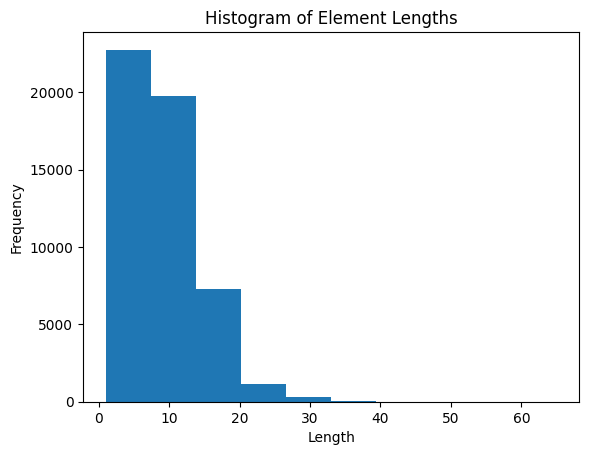

In [113]:
lengths = []
for element in X_train_token:
    lengths.append(len(element))

plt.hist(lengths, bins=10)  # Adjust the number of bins as needed
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Element Lengths')
plt.show()

In [114]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post', value=0, maxlen=40)
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post', value=0, maxlen=40)
X_train_pad

array([[1.2000e+01, 1.8795e+04, 1.9000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.8796e+04, 1.8797e+04, 1.2390e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.0400e+02, 4.9700e+02, 3.5470e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.0000e+00, 1.6942e+04, 6.0720e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [5.8430e+03, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.2650e+03, 1.4085e+04, 4.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]], dtype=float32)

In [115]:
y_train_cat = to_categorical(y_train, num_classes=30)
y_test_cat = to_categorical(y_test, num_classes=30)
y_train_cat.shape

(51300, 30)

In [116]:
vocab_size = len(tokenizer.word_counts)
vocab_size

36975

In [117]:
def initialize_model():
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=vocab_size+1, # 16 +1 for the 0 padding
        output_dim=20,
        input_length=40,
        mask_zero=True, # Built-in masking layer :)
    ))

    model.add(layers.Conv1D(30, kernel_size=3))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(30, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    
    return model

In [118]:
model_cnn = initialize_model()

es = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy")

history = model_cnn.fit(X_train_pad, y_train_cat, 
              epochs=1000, 
              batch_size=16,
              validation_split=0.3,
              callbacks=[es]
             )


res = model_cnn.evaluate(X_test_pad, y_test_cat, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

Train on 35910 samples, validate on 15390 samples


2023-06-14 17:40:36.549598: W tensorflow/c/c_api.cc:300] Operation '{name:'training_2/RMSprop/learning_rate/Assign' id:33090 op device:{requested: '', assigned: ''} def:{{{node training_2/RMSprop/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/RMSprop/learning_rate, training_2/RMSprop/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/1000
35856/35910 [============================>.] - ETA: 0s - loss: 2.8523 - accuracy: 0.1986

/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-06-14 17:40:45.186425: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_6/mul' id:33001 op device:{requested: '', assigned: ''} def:{{{node loss_6/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_6/mul/x, loss_6/dense_28_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


35910/35910 [==============================] - 10s 277us/sample - loss: 2.8518 - accuracy: 0.1988 - val_loss: 2.9563 - val_accuracy: 0.1557
Epoch 2/1000
35910/35910 [==============================] - 8s 219us/sample - loss: 2.2229 - accuracy: 0.3894 - val_loss: 2.9138 - val_accuracy: 0.2027
Epoch 3/1000
35910/35910 [==============================] - 8s 218us/sample - loss: 1.9294 - accuracy: 0.4755 - val_loss: 2.7570 - val_accuracy: 0.2607
Epoch 4/1000
35910/35910 [==============================] - 7s 202us/sample - loss: 1.7190 - accuracy: 0.5391 - val_loss: 2.6258 - val_accuracy: 0.3183
Epoch 5/1000
35910/35910 [==============================] - 7s 197us/sample - loss: 1.5609 - accuracy: 0.5857 - val_loss: 2.5110 - val_accuracy: 0.3423
Epoch 6/1000
35910/35910 [==============================] - 7s 200us/sample - loss: 1.4359 - accuracy: 0.6209 - val_loss: 2.5352 - val_accuracy: 0.3570
Epoch 7/1000
35910/35910 [==============================] - 7s 193us/sample - loss: 1.3318 - accurac

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

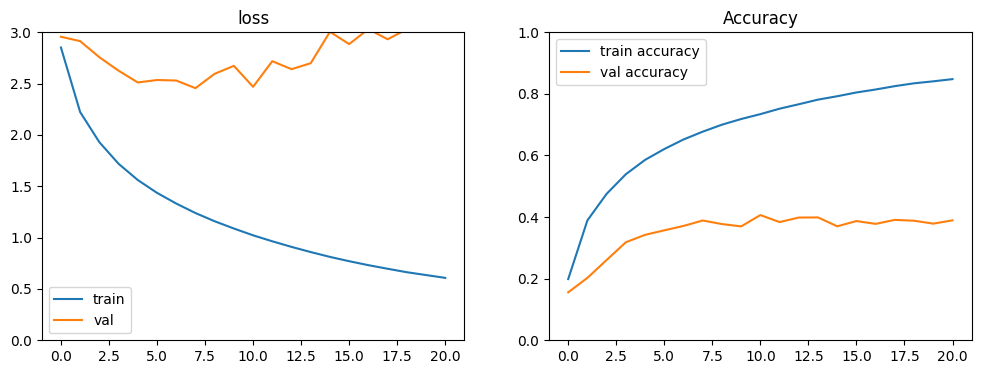

In [119]:
plot_history(history)

In [120]:
y_pred = np.argmax(model_cnn.predict(X_test_pad), axis=1)

/home/chris/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-06-14 17:43:15.732702: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_28/Softmax' id:32925 op device:{requested: '', assigned: ''} def:{{{node dense_28/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_28/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


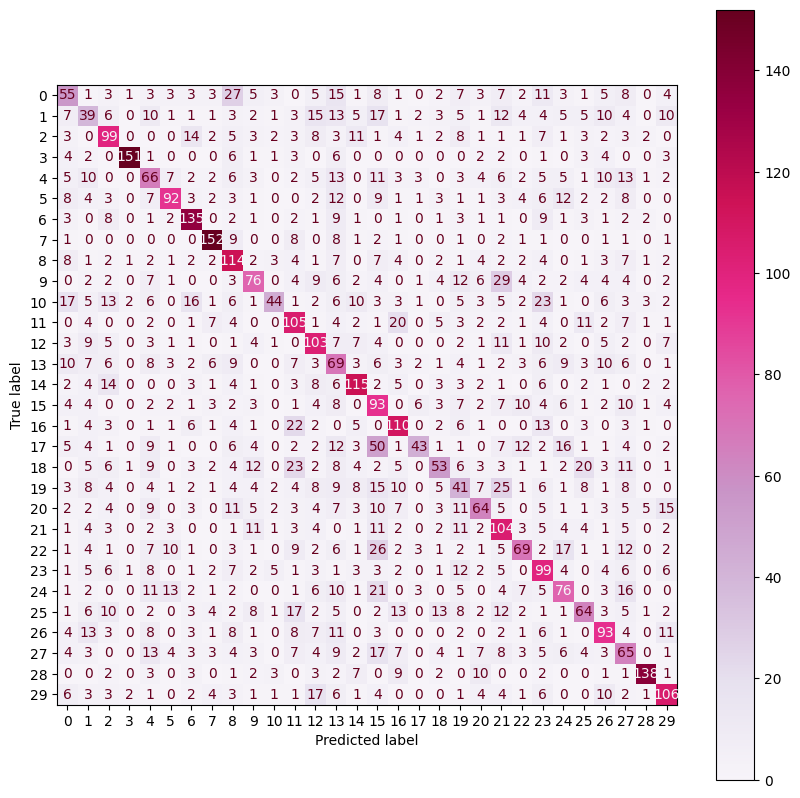

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

## Transfer learning tests

In [6]:
from transformers import AutoTokenizer

In [7]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# def tokenize_function(examples):
#     return tokenizer(examples[0], padding="max_length", truncation=True)
# tokenized_dataset = X_train.map(tokenize_function)              

In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenized_X_train = tokenizer(list(X_train), return_tensors="np", padding=True)
tokenized_X_train = dict(tokenized_X_train)
tokenized_X_test = tokenizer(list(X_test), return_tensors="np", padding=True)
tokenized_X_test = dict(tokenized_X_test)

In [9]:
tokenized_X_train

{'input_ids': array([[  101,  1556, 20452, ...,     0,     0,     0],
        [  101,  7085,  8376, ...,     0,     0,     0],
        [  101,  5514,  4354, ...,     0,     0,     0],
        ...,
        [  101,  1109, 27901, ...,     0,     0,     0],
        [  101, 15599,  4455, ...,     0,     0,     0],
        [  101, 14613,  5055, ...,     0,     0,     0]]),
 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])}

In [10]:
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [11]:
y_train_cat = to_categorical(y_train, num_classes=30)
y_test_cat = to_categorical(y_test, num_classes=30)

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=30)
model.compile(optimizer=Adam(3e-5),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit(tokenized_X_train, y_train_cat)

2023-06-14 19:09:33.772790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-14 19:09:33.773457: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

 229/1604 [===>..........................] - ETA: 7:50:25 - loss: 8.3663 - accuracy: 0.0308

In [ ]:
plot_history(history)

# Search space using optuna

In [125]:
def create_model(trial):
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=trial.suggest_int("embedding_units", 10, 50),
        input_length=40,
        mask_zero=True,
    ))

    model.add(layers.Conv1D(trial.suggest_int("conv_units", 10, 50), kernel_size=trial.suggest_int("kernel_size", 3, 5)))

    model.add(layers.Flatten())

    model.add(layers.Dense(30, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

    return model

def objective(trial):
    model = create_model(trial)
    es = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy")
    history = model.fit(X_train_pad, y_train_cat, 
                        epochs=1000,
                        batch_size=32,
                        validation_split=0.3,
                        callbacks=[es],
                        verbose=0)
    return history.history["val_accuracy"][-1]

In [126]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2023-06-14 17:43:20,081] A new study created in memory with name: no-name-a2a85dc5-75cc-4dcc-a5b4-27faf13b5d0c
2023-06-14 17:43:25.536910: W tensorflow/c/c_api.cc:300] Operation '{name:'training/RMSprop/dense/bias/rms/Assign' id:284 op device:{requested: '', assigned: ''} def:{{{node training/RMSprop/dense/bias/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/RMSprop/dense/bias/rms, training/RMSprop/dense/bias/rms/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-14 17:43:25.615699: W tensorflow/c/c_api.cc:300] Operation '{name:'training/RMSprop/dense/kernel/rms/Assign' id:279 op device:{requested: '', assigned: ''} def:{{{node training/RMSprop/dense/kernel/rms/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, d

2023-06-14 17:43:50.766588: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/mul' id:152 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-14 17:43:50.976838: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/mul' id:152 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-06-14 17:43:51.128482: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/

KeyboardInterrupt: 